![](fig/univ.png)

# AI-2: Convolutional Neural Network
## Homework 2: Convolutional Neural Network

**AI2 Cohort 1**<br/>
**Univ.AI**<br/>
**Instructor**: Pavlos Protopapas<br />
**Maximum Score**: 100

<hr style="height:2.4pt">

### INSTRUCTIONS


- This homework is a jupyter notebook. Download and work on it on your local machine.

- This homework should be submitted in pairs.

- Ensure you and your partner together have submitted the homework only once. Multiple submissions of the same work will be penalised and will cost you 2 points.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. 

- To submit the homework, either one of you upload the working notebook on edStem and click the submit button on the bottom right corner.

- Submit the homework well before the given deadline. Submissions after the deadline will not be graded.

- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.

- Comment your code well. This would help the graders in case there is any issue with the notebook while running. It is important to remember that the graders will not troubleshoot your code. 

- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example: 
```
print(f'The R^2 is {R:.4f}')
```
- Your plots should include clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95 % confidence interval of coefficients of polynomial degree 5" is).

- **Ensure you make appropraite plots for all the questions it is applicable to, regardless of it being explicitly asked for.**

<hr style="height:2pt">

### Names of the people who worked on this homework together
#### Chinmay Jain and Chaitanya Agarwal

In [ ]:
#RUN THIS CELL
import os
import pathlib
working_dir = pathlib.Path().absolute()
# Uncomment the line below to help debug if the path to included images don't show
#print(working_dir)
os.chdir(working_dir)

In [ ]:
# Please download the 2.1.0 version of tensorflow for this homework and also tf_keras_vis
!pip3 -qq install tf_keras_vis 
!pip -qq install tensorflow==2.1.0

In [ ]:
import os
import requests
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from glob import glob
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf


In [ ]:
tf.__version__

'2.1.0'

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Pysical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/datac_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.1.0
keras version 2.2.4-tf
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Pysical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Restart runtime and run the below cell to check if you have the correct version

print(tf.__version__)

2.1.0


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import os



import certifi
import urllib3  # For handling https certificate verification 
import scipy.ndimage as ndimage
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

import random
random.seed(42)
from PIL import Image

from matplotlib import pyplot
import matplotlib.pylab as plt 
from scipy.signal import convolve2d
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD

#Some imports for getting the CIFAR-10 dataset and for help with visualization*]
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

import tensorflow_addons as tfa

import os
import certifi
import urllib3  # For handling https certificate verification 
import scipy.ndimage as ndimage
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

## Please download the packages that are missing in your colab environment


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
<h1> Overview </h1> 

<br />

In this homework, we will explore Convolutional Neural Networks (CNNs).  We will begin by building a CNN to classify CIFAR-10 images, a standard pedagogical problem, and use saliency maps to understand what the network is paying attention to. We will then see that CNNs aren't just for classifying. They can serve as image input processing for a variety of tasks, as we will show by training a network to rotate faces upright.


<h2> Part 1: Building a Basic CNN Model [60pts total] </h2>
<br />

In this question, you will use Keras to create a convolutional neural network for predicting the type of object shown in images from the [CIFAR-10](https://keras.io/datasets/#cifar10-small-image-classification) dataset, which contains 50,000 32x32 training images and 10,000 test images of the same size, with a total of 10 sizes.

<br /><br />

<h4> Loading CIFAR-10 and Constructing the Model. </h4>
<br />

Load CIFAR-10 and use a combination of the following layers: Conv2D, MaxPooling2D, Dense, Dropout and Flatten Layers (not necessarily in this order, and you can use as many layers as you'd like) to build your classification model. You may use an existing architecture like AlexNet or VGG16, or create one of your own design. However, you should construct the network yourself and not use a pre-written implementation. At least one of your Conv2D layers should have at least 9 filters to be able to do question 1.3.
<br /><br />

Convolutional neural networks are computationally intensive. We highly recommend that you train your model on a system using GPUs (take a look at Google Colab's runtime settings for accessing a GPU environment free of cost). On CPUs, this training can take over an hour. On GPUs, it can be done within minutes. If you become frustrated having to rerun your model every time you open your notebook, take a look at how to save your model weights as explicitly detailed in **Part 2**, where it is required to save your weights.
<br /><br />

You can approach the problems in this question by first creating a model assigning 32 filters to each Conv2D layer recreate the model with 64 filters/layer, 128, etc. For each generated model, keep track of the total number of parameters.
<br /><br />

**1.1** [12pts] Report the total number of parameters in your model. How does the number of total parameters change (linearly, exponentially) as the number of filters per layer increases (your model should have at least 2 Conv layers)? You can find this empirically by constructing multiple models with the same type of architecture, increasing the number of filters. Generate a plot showing the relationship and explain why it has this relationship.
<br /><br />

**1.2** [14pts total] Choose a model, train and evaluate it.
<br /><br />

 **1.2.1** [10pts] Take your model from above and train it. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs.  Your validation accuracy should exceed 70%. Training for 10 epochs on a CPU should take about 30-60 minutes. 
 <br /><br />
 
**1.2.2** [4pts] Plot the loss and accuracy (both train and test) for your chosen architecture.
 <br /><br />
 
*Techniques to Visualize the Model.*
 <br /><br />
 
We will gain an intuition into how our model is processing the inputs in two ways.  First we'll ask you to use feature maps to visualize the activations in the intermediate layers of the network. We've provided a helper function `get_feature_maps` to aid in extracting feature maps from layer outputs in your model network.  Feel free to take advantage of it if you'd like.  We'll also ask you to use [saliency maps](https://arxiv.org/abs/1312.6034) to visualize the pixels that have the largest impact on the classification of an input (image in this case), as well as a more recent development,[Grad-CAM](https://arxiv.org/abs/1610.02391), which has been shown to better indicate the attention of CNNs.
 <br /><br />
 
**1.3** [10pts] For a given input image from the test set that is correctly classified, use your model and extract 9 feature maps from an intermediate convolutional layer of your choice and plot the images in a 3x3 grid (use `imshow`'s `cmap='gray'` to show the feature maps in black & white).  Make sure to plot (and clearly label) your original input image as well. You may use the provided `get_feature_maps` function and the `cifar10dict` dictionary to convert class index to the correct class name.
 <br /><br />
 
**1.4** [10pts] For the same input image generate and plot a (SmoothGrad) saliency map to show the pixels in the image most pertinent to classification, and a Grad-CAM heatmap. This is most easily done with the [tf-keras-vis](https://pypi.org/project/tf-keras-vis/) package. Take a look at the "Usage" examples; it will be straightforward to apply to our model. Feel free to pick your own [colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html); the `jet` colormap is harder to interpret than sequential ones. Arrange the three plots in a row using subplots: Original Image, Saliency Map, GradCAM. Which visualization is easier to understand in your case, and what does the network seem to be focusing on?
 <br /><br />
 
**1.5** [14pts] Repeat `1.4` for an image from the test set that is *incorrectly classified*, indicating both the incorrect label and what the correct label should be, and from the visualizations of network attention, hypothesize why the network arrived at its answer. (Make sure you pass a new loss to the visualizers that uses the *incorrect* class index, because we want to see what caused the network to think the image was in that category!) If you had control over what images go in the training dataset, how could you modify it to avoid this particular network failure?



</div>




**Helper code to generate feature maps**

In [ ]:
def get_feature_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

**A dictionary to turn class index into class labels for CIFAR-10**

In [ ]:
cifar10dict = {0 : 'airplane', 1 : 'automobile', 2 : 'bird', 3 : 'cat', 4 : 'deer', 5 : 'dog', 6 : 'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

### 1.1


**1.1 [12pts]** Report the total number of parameters in your model. How does the number of total parameters change (linearly, exponentially) as the number of filters per layer increases (your model should have at least 2 Conv layers)? You can find this empirically by constructing multiple models with the same type of architecture, increasing the number of filters. Generate a plot showing the relationship and explain why it has this relationship.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

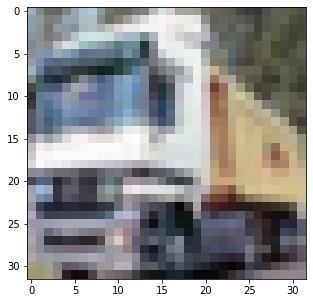

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(x_train[1], aspect='auto', cmap=plt.cm.binary, interpolation ='nearest')
plt.show()

In [ ]:
#Creating 10 models with different number of filters
randomlist = random.sample(range(8, 2000), 100)
params = []
k=0
# list(range(8, 1024))
for i in randomlist:
  model_ = Sequential([
                       Conv2D(i, (3,3), activation='relu', input_shape=(32, 32, 3)),
                       Conv2D(i, (3,3), activation='relu'),
                       MaxPooling2D(2,2),
                       Conv2D(i, (3,3), activation='relu'),
                       Conv2D(i, (3,3), activation='relu'),
                       MaxPooling2D(2,2),
                       Flatten(),
                       Dense(128, activation='relu'),
                       Dense(10, activation='softmax')
                       ])
  
  #loop for finding total number of parameters
  p=0
  for layer in model_.layers:
    try:
      p = p + (layer.weights[0].shape[0] * layer.weights[0].shape[1] * layer.weights[0].shape[2] * layer.weights[0].shape[3])
      p = p + (layer.weights[1].shape[0])

    except:
      if (len(layer.weights) != 0):
        p = p +  (layer.weights[0].shape[0] * layer.weights[0].shape[1]) + layer.weights[1].shape[0]
      pass
  params.append(p)
  tf.keras.backend.clear_session()
  tf.compat.v1.reset_default_graph()

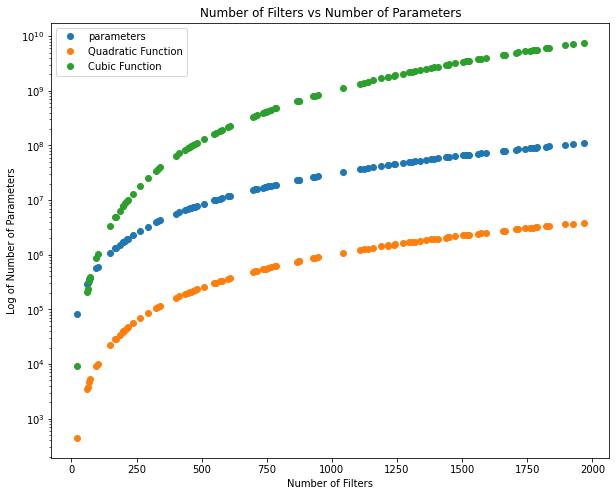

In [ ]:
filters = [i for i in randomlist]
plt.figure(figsize=(10, 8)) 
plt.semilogy(filters, params, 'o', label = 'parameters')
plt.title('Number of Filters vs Number of Parameters')
plt.xlabel('Number of Filters')
plt.ylabel('Log of Number of Parameters')
# a=[1,2,3,4,5,6,7,8,9,10]
# b=[1,4,9,16,25,36,49,64,81,100] #b=a+1
b = [(i**2)for i in randomlist]
c = [i**3 for i in randomlist]
plt.plot(filters,b, 'o', label='Quadratic Function')
plt.semilogy(filters,c, 'o', label='Cubic Function')
plt.legend()
plt.show()

## Since in a ***Semi-log*** graph, the plot is curved and between the quadratic and cubic function, therefore the number of parameters grows nearly with a power of 2.5 with the number of filters.
## Since the number of filters in conv layer is kernel_size x no_of_filter x depth_of previous layer + no_of_filter. So in the middle layers the parameters will be nearly i^2+i where i is the no_of_filters.But in the final fully connected layers the parameters increases 128 x i times.So if we sum the parameters of all the layers its between quadratic and cubic function.

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

In [ ]:
model = Sequential([Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001), input_shape=(32, 32, 3)),
                    Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    MaxPooling2D(2,2),
                    Dropout(0.3),
                    tf.keras.layers.BatchNormalization(),
                    Dropout(0.35),
                    Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    MaxPooling2D(2,2),
                    Dropout(0.3),
                    tf.keras.layers.BatchNormalization(),
                    Dropout(0.35),
                    Flatten(),
                    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Dropout(0.45),
                    tf.keras.layers.BatchNormalization(),
                    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Dropout(0.4),
                    tf.keras.layers.BatchNormalization(),
                    Dense(10, activation='softmax')])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        3

In [ ]:
print('Total number of parameters: 662,730')

Total number of parameters: 662,730


### 1.2

**1.2 Choosing a Model, Training and Evaluating It. [7pts total]**


 **[10pts]** Take your model from above and train it. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs.  Your validation accuracy should exceed 70%. Training for 10 epochs on a CPU should take about 30-60 minutes.
 
 **[4pts]** Plot the loss and accuracy (both train and test) for your chosen architecture.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs=150, verbose=2, callbacks=[es, lr], validation_data=(x_test, y_test), workers=8, use_multiprocessing=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/150
50000/50000 - 7s - loss: 2.0768 - accuracy: 0.3021 - val_loss: 2.4070 - val_accuracy: 0.2164
Epoch 2/150
50000/50000 - 5s - loss: 1.5903 - accuracy: 0.4563 - val_loss: 1.6140 - val_accuracy: 0.4774
Epoch 3/150
50000/50000 - 5s - loss: 1.4129 - accuracy: 0.5271 - val_loss: 1.2852 - val_accuracy: 0.5725
Epoch 4/150
50000/50000 - 5s - loss: 1.2966 - accuracy: 0.5761 - val_loss: 1.1250 - val_accuracy: 0.6346
Epoch 5/150
50000/50000 - 5s - loss: 1.2058 - accuracy: 0.6128 - val_loss: 1.0954 - val_accuracy: 0.6516
Epoch 6/150
50000/50000 - 5s - loss: 1.1459 - accuracy: 0.6375 - val_loss: 1.0501 - val_accuracy: 0.6683
Epoch 7/150
50000/50000 - 5s - loss: 1.0995 - accuracy: 0.6539 - val_loss: 0.9876 - val_accuracy: 0.6968
Epoch 8/150
50000/50000 - 5s - loss: 1.0619 - accuracy: 0.6687 - val_loss: 0.9548 - val_accuracy: 0.7031
Epoch 9/150
50000/50000 - 5s - loss: 1.0398 - accuracy: 0.6797 - val_loss: 0.8863 - val_accuracy: 0.7367
Epoch

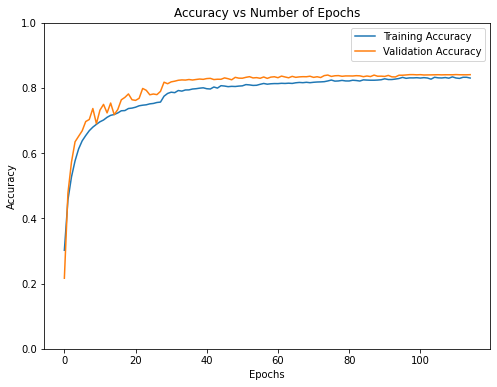

In [ ]:
plt.figure(figsize=(8, 6)) 
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy vs Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

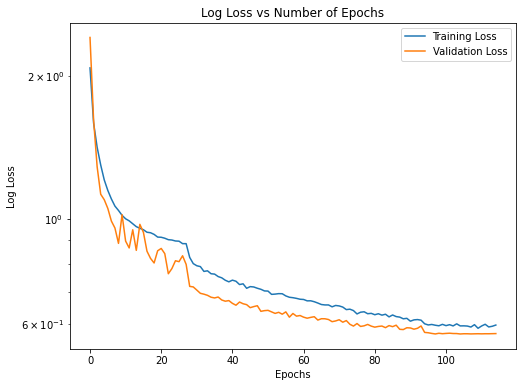

In [ ]:
plt.figure(figsize=(8, 6)) 
plt.semilogy(history.history['loss'], label='Training Loss')
plt.semilogy(history.history['val_loss'], label = 'Validation Loss')
plt.title('Log Loss vs Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('Test accuracy:',test_acc, end='')

10000/10000 - 1s - loss: 0.5710 - accuracy: 0.8401
Test accuracy: 0.8401

### 1.3


**1.3 [10pts]** For a given input image from the test set that is correctly classified, use your model and extract 9 feature maps from an intermediate convolutional layer of your choice and plot the images in a 3x3 grid (use `imshow`'s `cmap='gray'` to show the feature maps in black & white).  Make sure to plot (and clearly label) your original input image as well. You may use the provided `get_feature_maps` function and the `cifar10dict` dictionary to convert class index to the correct class name.

In [ ]:
n=1

pred = model.predict(x_test[n].reshape(1, 32, 32, 3)).tolist()
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

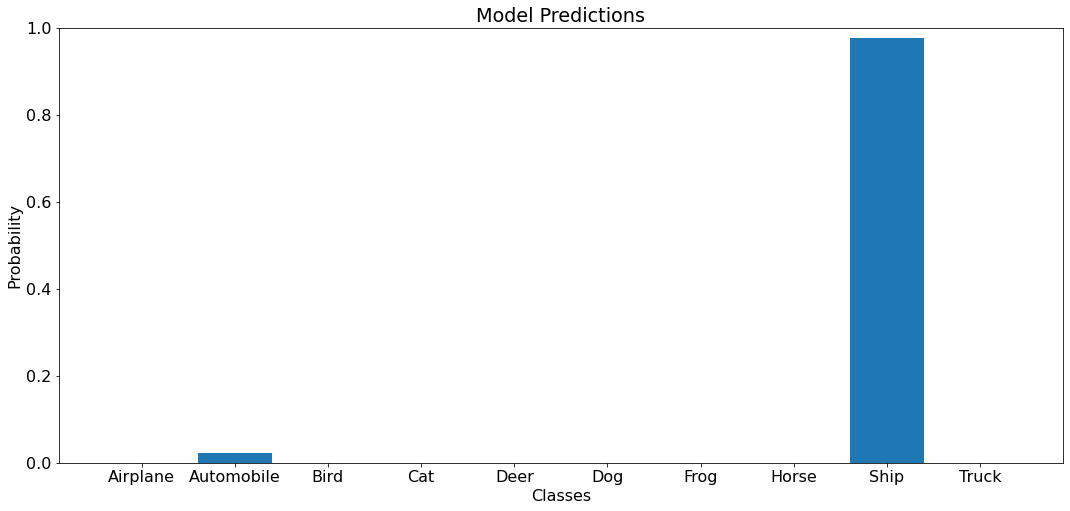

In [ ]:
plt.figure(figsize=(18, 8))
plt.rcParams.update({'font.size': 16})
plt.bar(classes, pred[0])
plt.title('Model Predictions')
plt.ylabel('Probability')
plt.xlabel('Classes')
plt.ylim([0, 1])
plt.show()

ship 



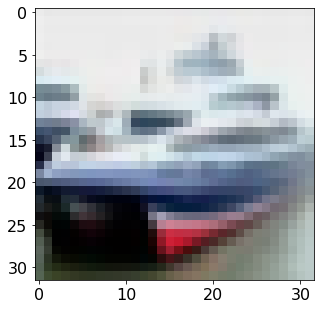

In [ ]:
#Displaying a Test image that is correctly classified
plt.figure(figsize=(5,5))
plt.imshow(x_test[n], aspect='auto', cmap=plt.cm.binary, interpolation ='nearest')
print(cifar10dict.get(np.argmax(y_test[n])),'\n')
plt.show()

<Figure size 1440x720 with 0 Axes>

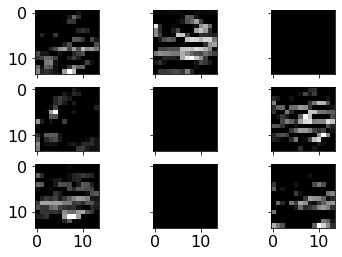

In [ ]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
k=10
layer_image=get_feature_maps(model, 3, x_test[n], )
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(layer_image[k],cmap='gray')
        k=k+1

plt.show()

### 1.4

**1.4 [10pts]** For the same input image generate and plot a (SmoothGrad) saliency map to show the pixels in the image most pertinent to classification, and a Grad-CAM heatmap. This is most easily done with the [tf-keras-vis](https://pypi.org/project/tf-keras-vis/) package. Take a look at the "Usage" examples; it will be straightforward to apply to our model. Feel free to pick your own [colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html); the `jet` colormap is harder to interpret than sequential ones. Arrange the three plots in a row using subplots: Original Image, Saliency Map, GradCAM. Which visualization is easier to understand in your case, and what does the network seem to be focusing on?

In [ ]:
# your code here
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

def saliency_graphs(model, img):
    saliency = Saliency(model, model_modifier)
  # input image that is pre-processed
    input_image =  np.expand_dims(img, axis=0)
  # predict on the input image
    y_pred = model.predict(input_image)
    y_pred=np.argmax(y_pred)
    class_idxs = y_pred
    loss = lambda output: tf.keras.backend.mean(output[:, class_idxs])
    saliency_map = saliency(loss, input_image,smooth_noise=0.10,smooth_samples=20)
    saliency_map = normalize(saliency_map)
    return saliency_map

def gradcam_graphs(model, img):
    gradcam = Gradcam(model, model_modifier)
  # input image that is pre-processed
    input_image =  np.expand_dims(img, axis=0)
  # predict on the input image
    y_pred = model.predict(input_image)
    y_pred=np.argmax(y_pred)
    class_idxs = y_pred
    loss = lambda output: tf.keras.backend.mean(output[:, class_idxs])
    cam = gradcam(loss,input_image,penultimate_layer=-1)
    cam = normalize(cam)
    return cam

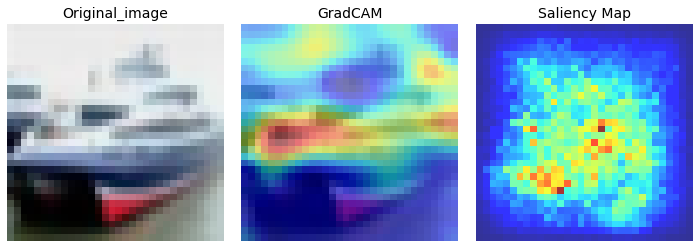

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
cam=gradcam_graphs(model, x_test[n])
heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
heatmap = np.reshape(heatmap,(32,32,3))
#ax[i].set_title(title, fontsize=14)
ax[0].set_title('Original_image', fontsize=14)
ax[1].set_title('GradCAM', fontsize=14)
ax[2].set_title('Saliency Map', fontsize=14)
ax[0].imshow(x_test[n])
ax[1].imshow(x_test[n])
ax[1].imshow(heatmap, cmap='jet', alpha=0.5)# overlay
ax[2].imshow(saliency_graphs(model, x_test[n])[0], cmap='jet',alpha=0.8)
ax[0].grid(False)
ax[0].axis('off')
ax[1].grid(False)
ax[1].axis('off')
ax[2].grid(False)
ax[2].axis('off')
plt.tight_layout()
plt.show()

# GradCAM is easier to understand in our case as we can see the image in the background. In this image we can see the model is focusing on the uper part of the ship, and the sky which is white.

### 1.5
**[14pts]** Repeat *1.4* for an image from the test set that is *incorrectly classified*, indicating both the incorrect label and what the correct label should be, and from the visualizations of network attention, hypothesize why the network arrived at its answer. (Make sure you pass a new loss to the visualizers that uses the *incorrect* class index, because we want to see what caused the network to think the image was in that category!) If you had control over what images go in the training dataset, how could you modify it to avoid this particular network failure?

In [ ]:
m=85

pred = model.predict(x_test[m].reshape(1, 32, 32, 3)).tolist()
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

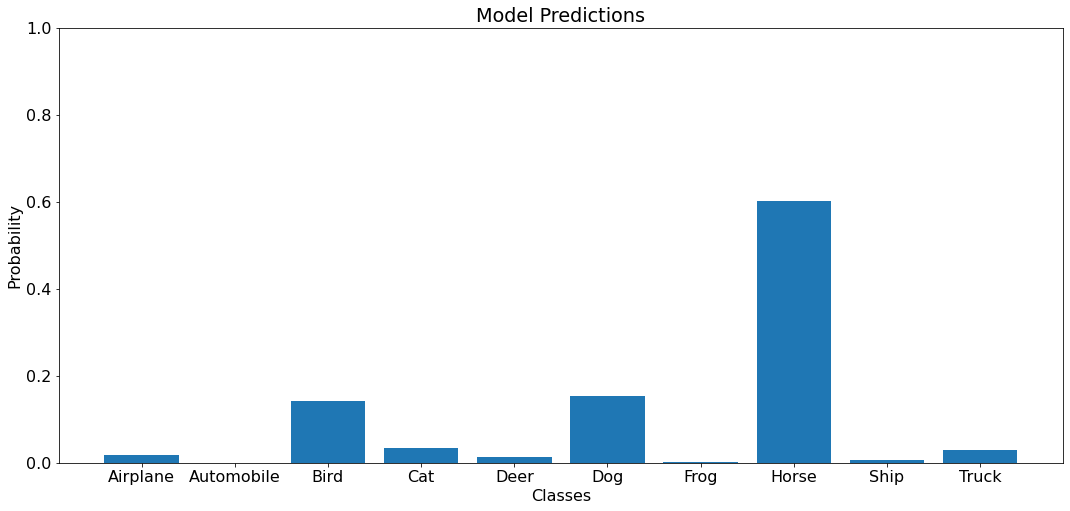

In [ ]:
plt.figure(figsize=(18, 8))
plt.rcParams.update({'font.size': 16})
plt.bar(classes, pred[0])
plt.title('Model Predictions')
plt.ylabel('Probability')
plt.xlabel('Classes')
plt.ylim([0, 1])
plt.show()

Incorrect
True Label = dog
Predicted Label = horse


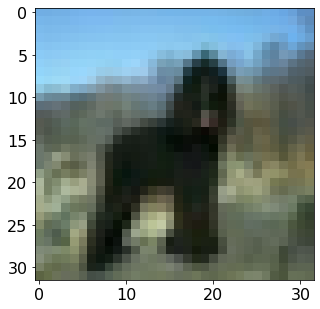

In [ ]:
#Displaying a Test image that is correctly classified
y_pred=model.predict(np.expand_dims(x_test[m], axis=0))
y_pred=cifar10dict[np.argmax(y_pred)]
y_true=cifar10dict[np.argmax(y_test[m])]
if(y_true!=y_pred):
    print("Incorrect")
    print("True Label =",y_true)
    print("Predicted Label =",y_pred)

plt.figure(figsize=(5,5))
plt.imshow(x_test[m], aspect='auto', cmap=plt.cm.binary, interpolation ='nearest')
# print(cifar10dict.get(np.argmax(y_test[m])),'\n')
plt.show()

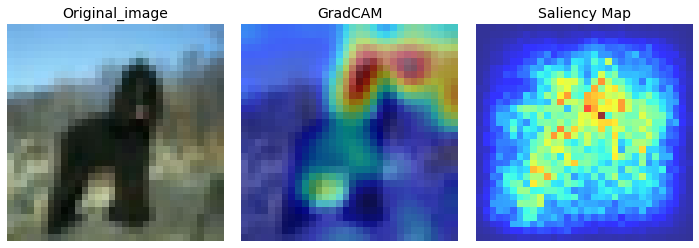

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
cam=gradcam_graphs(model, x_test[m])
heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
heatmap = np.reshape(heatmap,(32,32,3))
#ax[i].set_title(title, fontsize=14)
ax[0].set_title('Original_image', fontsize=14)
ax[1].set_title('GradCAM', fontsize=14)
ax[2].set_title('Saliency Map', fontsize=14)
ax[0].imshow(x_test[m])
ax[1].imshow(x_test[m])
ax[1].imshow(heatmap, cmap='jet', alpha=0.5)# overlay
ax[2].imshow(saliency_graphs(model, x_test[m])[0], cmap='jet',alpha=0.8)
ax[0].grid(False)
ax[0].axis('off')
ax[1].grid(False)
ax[1].axis('off')
ax[2].grid(False)
ax[2].axis('off')
plt.tight_layout()
plt.show()

# We can see the model is focusing more on the background pixel which is of a ground and on the uper part of the legs of dog and on the face.
# The model is baised towards the color and predicts it as horse and the image is also so pixelated we ourself cannot truly say which animal it is.
# if I had control over what images go in the training dataset then I would have sent a more clear images than these.

<div class='exercise'> <b> Question 2: Image Orientation Estimation [30pts] </b></div>

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
    
<h2> Part 2: Regression with CNN [40pts total] </h2>

## Problem Statement

In this problem we will construct a neural network to predict *how far a face is from being "upright"*. 

Image orientation estimation with convolutional networks was first implemented in 2015 by Fischer, Dosovitskiy, and Brox in a paper titled ["Image Orientation Estimation with Convolutional Networks"](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf), where the authors trained a network to straighten a wide variety of images using the Microsoft COCO dataset. 

In order to have a reasonable training time for a homework, we will be working on a subset of the problem where we just straighten images of faces. To do this, we will be using the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset of celebrity faces, where we assume that professional photographers have taken level pictures. 

The training will be supervised, with a rotated image (up to $\pm 60^\circ$) as an input, and the amount (in degrees) that the image has been rotated as a target. 
    
</div>

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
    
<h2> Questions </h2>

### Data preparation [20 points]

**2.1.1[10 points]** **Loading CelebA and Thinking about Datasets**.

Run the cells provided to automatically download the CelebA dataset. It is about 1.3GB, which can take 10-20 minutes to download. This happens only once; in the future when you rerun the cell, it will use the dataset stored on your google drive.

**NOTE**: If you get a `NonMatchingChecksumError`, note that this is a documented issue and is because of multiple server requests. Refer [here](https://github.com/tensorflow/datasets/issues/1482) for more details.

The creation of the normalization/rotation/resize pipeline has been done for you, resulting in train dataset `train_rot_ds` and test dataset `test_rot_ds`. 

[TensorFlow Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) are objects that behave like Python generators, allowing you to take elements (either input/target tuples or feature dictionaries) until you have gone through the entire dataset. Note how this is different from part 1 where the entire dataset was loaded in as an array. 

Datasets also allow you to pipeline transformations to be applied to the elements, resulting in a new transformed Dataset (like `train_rot_ds`). 

Explain in less than 150 words why using this approach is advantageous over loading the entire data in one array.

   
**2.1.2[5 points]** **Taking a look**.

In a grid of subplots, plot at least 4 rotated images from `train_rot_ds` with the titles being the amount the images have been rotated. The floating point numbers in the titles should have a reasonable number of digits. 

Hint: one way to get a few image+label tuples from the Dataset is with `train_rot_ds.take(4)`. Check the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for more.

**2.1.3[5 points]** **Conceptual Question**

Dropout layers have been shown to work well for regularizing deep neural networks, and can be used for very little computational cost. 

Write in **3-5 sentences** if it is a good idea to use dropout layers? 

Explain, being sure to explicitly discuss how a dropout layer works, and what that would mean for our model.

### Building and training your CNN [20 points]

**2.2.1[5 points]** **Compiling your model**.

Construct a model with multiple Conv layers and any other layers you think would help. Be sure to output `<yourmodelname>.summary()` as always. Feel free to experiment with architectures and number of parameters if you wish to get better performance or better training speed. You certainly don't need more than a few million parameters; we were able to it with substantially fewer. Any working setup is acceptable though.

**2.2.2[10 points]** **Training your model**.

Train your model using `<yourmodelname>.fit()`. The syntax is a little different when working with Datasets instead of numpy arrays; take a look at the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation. Be sure to also pass the test data as validation data. When passing `train_rot_ds` to `fit()`, you will find it useful to use pipelines to [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the data. You can also experiment with [prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) batches/elements from the dataset, which may allow you to speed up iterations by a few percent. Finally, while dry-running and prototyping your model, you may find it useful to [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) a subset of the data to speed up experimentation. Your final model should be trained on all the available training data though. You should achieve a validation loss of less than 9, corresponding to $\pm 3^\circ$ accuracy in predicting the rotations on the test set. This can be achieved in just 2-3 epochs, though you are free to train as long as you want.

**2.2.3[5 points]** **Evaluating your model**.

Create a subplots grid with 4 rows and 3 columns. Each row will be a separate image from the test set (of your choice) and each column will consist of: Original Image, Predicted Straightened Image, Target Straightened Image. The title of the latter two should be the predicted rotation and the actual rotation. For example, a row should look something like this:

This can be achieved using the provided function `rot_resize` to correct for the rotation predicted by your network.

### Further Analysis [10 points]

**2.3.1[8 points]** **Visualizing Attention**.

Like in part 1, we will use the saliency map and GradCAM to see what the network was looking at to determine the orientation of a testset image. 

The code will be very similar to what you used in part 1, but there are two important modifications. 

In defining the new `model_modifier(m)` function, simply replace the contents with `pass`. This is because your model does not (should not) have a softmax activation on the last layer, so we don't need this function to do anything. 

The other modification is to change the loss function (that was defined as a Python lambda function) to an MSE, so it should now be `tf.keras.backend.mean((output - label)**2)` where label is the actual rotation of the image. Pick any image from the test set, and like before, make a row of 3 subplots showing the original image, the saliency map, and the GradCAM output. 

Answer in 1-2 lines what types of features does the network appear to use to determine orientation?

**2.3.2[2 points]** **Correct an image of your choosing**.

Find an image or image(s) (not from the provided test/training sets), or make your own. You may rotate it yourself up to $\pm60^\circ$, or the face can already be naturally rotated. Resize and crop the image to 140px by 120px, load it here, and normalize it to [0.,1.] (you may use the provided `normalize_image` function) and use your network to correct it.
    
</div>

**2.1.1** **Loading CelebA and Thinking about Datasets**.

Run the cells provided to automatically download and load the CelebA dataset. It is about 1.3GB, and may take some time to download. Please ensure you are running the `2.1.0` version of tensorflow.

The creation of the normalization/rotation/resize pipeline has been done for you, resulting in train dataset `train_rot_ds` and test dataset `test_rot_ds`. 

[TensorFlow Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) are objects that behave like Python generators, allowing you to take elements (either input/target tuples or feature dictionaries) until you have gone through the entire dataset. Note how this is different from part 1 where the entire dataset was loaded in as an array. 

Datasets also allow you to pipeline transformations to be applied to the elements, resulting in a new transformed Dataset (like `train_rot_ds`). 

In [ ]:
#mount your own drive to avoid downloading the data multiple time 

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Following creates a directory, downloads the file and unzips it. 

if os.path.isdir('gdrive/My Drive/celeb_a/2.0.1'):
    print('Found dataset' )
else:
    os.makedirs('gdrive/My Drive/celeb_a')
    !gdown -qq https://drive.google.com/u/2/uc?id=1CdfrT4f87b8ggx02TxsBuMTu0bqSIpNX&export=download
    !unzip 2.0.1.zip  -d gdrive/My\ Drive/celeb_a/

Found dataset


In [ ]:
# This command will use the celeb_a dataset that you downloaded, and load it into train and test 'tensorflow.Datasets'

train_celeb, test_celeb = tfds.load('celeb_a', split=['train', 'test'], shuffle_files=False, data_dir = 'gdrive/My Drive/', download=False)

In [ ]:
# You may use the following two functions
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def rot_resize(img, deg):
    rotimg = ndimage.rotate(img, deg, reshape=False, order=3)
    rotimg = np.clip(rotimg, 0., 1.)
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
    return rotimg

################################################################
# Don't manually invoke these functions; they are for Dataset 
# pipelining that is already done for you.
################################################################
def tf_rot_resize(img, deg):
    """Dataset pipe that rotates an image and resizes it to 140x120"""
    rotimg = tfa.image.rotate(img, deg/180.*np.pi, interpolation="BILINEAR")
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
    return rotimg

def tf_random_rotate_helper(image):
    """Dataset pipe that normalizes image to [0.,1.] and rotates by a random
    amount of degrees in [-60.,60.], returning an (input,target) pair consisting
    of the rotated and resized image and the degrees it has been rotated by."""
    image = normalize_image(image)
    deg = tf.random.uniform([],-60.,60.)
    return (tf_rot_resize(image,deg), deg)  # (data, label)

def tf_random_rotate_image(element):
    """Given an element drawn from the CelebA dataset, this returns a rotated
    image and the amount it has been rotated by, in degrees."""
    image = element['image']
    image, label = tf_random_rotate_helper(image)
    image.set_shape((140,120,3))
    return image, label
################################################################

In [ ]:
# Pipeline for creating randomly rotated images with their target labels being 
# the amount they were rotated, in degrees.
train_rot_ds = train_celeb.map(tf_random_rotate_image)
test_rot_ds = test_celeb.map(tf_random_rotate_image)

***Using this approach has many advantages:***

*   We do not need to load the whole data and keep it locally in the program. We can keep it on the cloud and get the data whenever we want. Thus, we don't need to have large storage locally in the era of Big Data.
*   We can use pipelining to augment the data on the fly. We don't need to preprocess the data before-hand, each example gets preprocessed while training. This saves a lot of time and energy which can be used to improve the model architecture which is of greater importance.



**2.1.2** **Taking a look**.

In a grid of subplots, plot at least 4 rotated images from `train_rot_ds` with the titles being the amount the images have been rotated. The floating point numbers in the titles should have a reasonable number of digits. 

Hint: one way to get a few image+label tuples from the Dataset is with `train_rot_ds.take(4)`. Check the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for more.

In [ ]:
images=list(train_rot_ds.take(4).as_numpy_iterator())
images=np.array(images)
print(images.shape)

(4, 2)


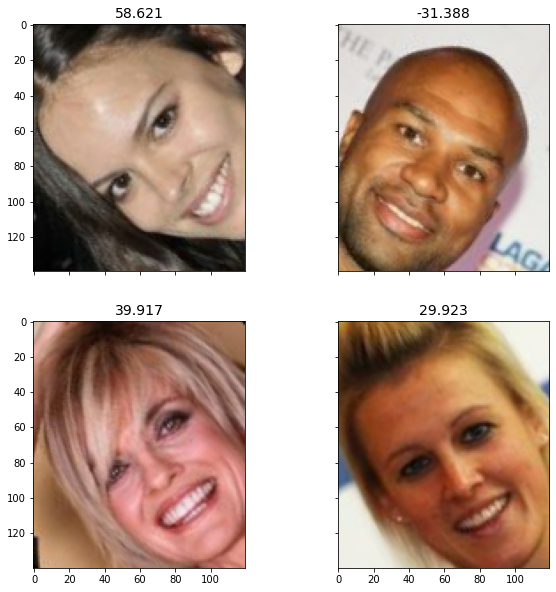

In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(10, 10))
k=0
for i in range(2):
    for j in range(2):
        ax[i,j].set_title(np.round(images[k,1],3), fontsize=14)#rounded off to 3 decimal points
        ax[i,j].imshow(images[k,0])
        k=k+1

**2.1.3** **Conceptual Question**

Dropout layers have been shown to work well for regularizing deep neural networks, and can be used for very little computational cost. 

Write in **3-5 sentences** if it is a good idea to use dropout layers? 

Explain, being sure to explicitly discuss how a dropout layer works, and what that would mean for our model.

# Answer
# Deep learning neural networks are prone to overfitting. There are many ways to regularise a model but many of them are computationally expensive and also increases the number of parameters to be learned. Dropout on the other hand is computationally efficient as it effectively reduces the number of parameters to be learned during each iteration.*
# By dropping a unit out, we mean temporarily removing it from the network, along with all its incoming and outgoing connections. Due to this, one node can not depend on the other as in the subsequent iteration, that node might be dropped. It is a good idea to use dropout since it doesn't has any new parameters to learn and hence are not computationally expensive.*

**2.2.1** **Compiling your model**.

Construct a model with multiple Conv layers and any other layers you think would help. Be sure to output `<yourmodelname>.summary()` as always. Feel free to experiment with architectures and number of parameters if you wish to get better performance or better training speed. You certainly don't need more than a few million parameters; we were able to it with substantially fewer. Any working setup is acceptable though.

In [ ]:
model = Sequential([Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001), input_shape=(140, 120, 3)),
                    #Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    MaxPooling2D(2,2),
                    # Dropout(0.3),
                    # tf.keras.layers.BatchNormalization(),
                    # Dropout(0.35),
                    #Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    MaxPooling2D(2,2),
                    # Dropout(0.3),
                    # tf.keras.layers.BatchNormalization(),
                    # Dropout(0.35),
                    Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    MaxPooling2D(2,2),

                    Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    MaxPooling2D(2,2),
                    # Dropout(0.3),
                    # tf.keras.layers.BatchNormalization(),
                    #Dropout(0.35),
                    Flatten(),
                    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    # Dropout(0.45),
                    # tf.keras.layers.BatchNormalization(),
                    # Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    # Dropout(0.4),
                    # tf.keras.layers.BatchNormalization(),
                    Dense(1, activation='linear')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 138, 118, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 69, 59, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 67, 57, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 11, 32)        9

**2.2.2** **Training your model**.

Train your model using `<yourmodelname>.fit()`. The syntax is a little different when working with Datasets instead of numpy arrays; take a look at the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation. Be sure to also pass the test data as validation data. When passing `train_rot_ds` to `fit()`, you will find it useful to use pipelines to [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the data. You can also experiment with [prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) batches/elements from the dataset, which may allow you to speed up iterations by a few percent. Finally, while dry-running and prototyping your model, you may find it useful to [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) a subset of the data to speed up experimentation. Your final model should be trained on all the available training data though. You should achieve a validation loss of less than 9, corresponding to $\pm 3^\circ$ accuracy in predicting the rotations on the test set. This can be achieved in just 2-3 epochs, though you are free to train as long as you want.

In [ ]:
es = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, verbose=1)
lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
train_rot_ds = train_rot_ds.cache()
train_rot_ds = train_rot_ds.shuffle(32)
train_rot_ds_ = train_rot_ds.batch(32)
train_rot_ds_ = train_rot_ds_.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
test_rot_ds_ = test_rot_ds.batch(32)
test_rot_ds_ = test_rot_ds_.cache()
test_rot_ds_ = test_rot_ds_.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
history = model.fit(train_rot_ds_,
    epochs=3,   #since while training colab was running out of RAM, we couldn't increase the number of epochs. We instead trained it multiple times with epoch=3
    steps_per_epoch=300,
    validation_data=test_rot_ds_,
    validation_steps = 50,
    callbacks = [es, lr], use_multiprocessing=True, workers=8)

Train for 300 steps, validate for 50 steps
Epoch 1/3
300/300 [==============================] - 49s 162ms/step - loss: 15.5837 - val_loss: 26.7183
Epoch 2/3
300/300 [==============================] - 46s 153ms/step - loss: 14.9263 - val_loss: 14.6852
Epoch 3/3
300/300 [==============================] - 47s 156ms/step - loss: 13.8726 - val_loss: 13.3314


In [ ]:
model.save("my_h5_model.h5")

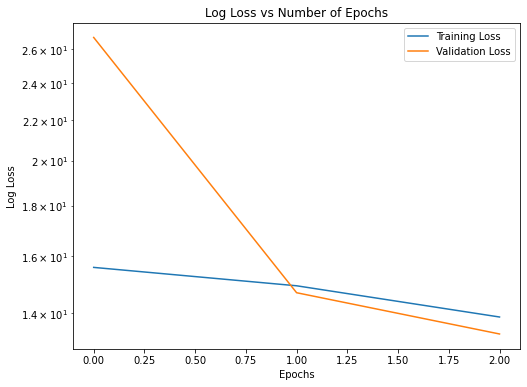

In [ ]:
plt.figure(figsize=(8, 6)) 
plt.semilogy(history.history['loss'], label='Training Loss')
plt.semilogy(history.history['val_loss'], label = 'Validation Loss')
plt.title('Log Loss vs Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

**2.2.3** **Evaluating your model**.

Create a subplots grid with 4 rows and 3 columns. Each row will be a separate image from the test set (of your choice) and each column will consist of: Original Image, Predicted Straightened Image, Target Straightened Image. The title of the latter two should be the predicted rotation and the actual rotation. For example, a row should look something like this:

This can be achieved using the provided function `rot_resize` to correct for the rotation predicted by your network.

In [ ]:
images=list(test_rot_ds.take(4).as_numpy_iterator())
images=np.array(images)

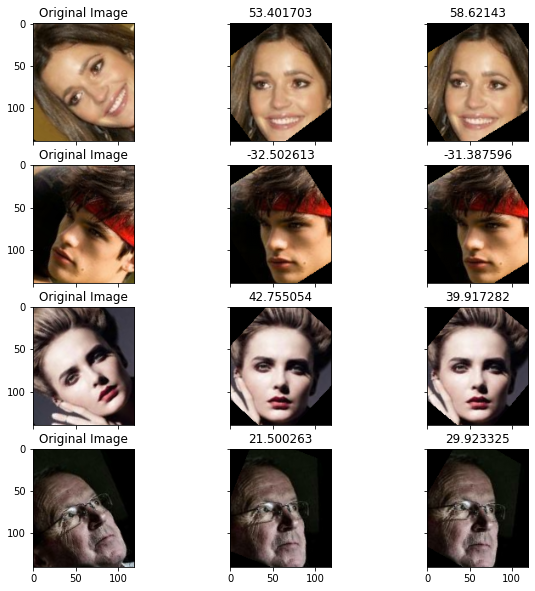

In [ ]:
fig, ax = plt.subplots(4, 3, sharex=True, sharey=True,figsize=(10, 10))
k=0
for i in range(4):
  ax[i,0].imshow(images[k,0])
  ax[i,0].set_title('Original Image')

  ax[i,1].imshow(rot_resize(images[k,0], -model.predict(images[k,0].reshape(1, 140, 120, 3))[0][0]))  #-ve sign to straighten the image
  ax[i,1].set_title(model.predict(images[k,0].reshape(1, 140, 120, 3))[0][0])

  ax[i,2].imshow(rot_resize(images[k,0], -images[k,1]))   #-ve sign to straighten the image
  ax[i,2].set_title(images[k,1])

  k=k+1
plt.show()

**2.3.1** **Visualizing Attention**.

Like in part 1, we will use the saliency map and GradCAM to see what the network was looking at to determine the orientation of a testset image. 

The code will be very similar to what you used in part 1, but there are two important modifications. 

In defining the new `model_modifier(m)` function, simply replace the contents with `pass`. This is because your model does not (should not) have a softmax activation on the last layer, so we don't need this function to do anything. 

The other modification is to change the loss function (that was defined as a Python lambda function) to an MSE, so it should now be `tf.keras.backend.mean((output - label)**2)` where label is the actual rotation of the image. Pick any image from the test set, and like before, make a row of 3 subplots showing the original image, the saliency map, and the GradCAM output. 

Answer in 1-2 lines what types of features does the network appear to use to determine orientation?

In [ ]:
def model_modifier(m):
    pass

def saliency_graphs(model, img,label):
    saliency = Saliency(model, model_modifier)
  # input image that is pre-processed
    input_image =  np.expand_dims(img, axis=0)
  # predict on the input image
    y_pred = model.predict(input_image)[0][0]
    # output = y_pred
    loss =lambda output: tf.keras.backend.mean((output - label)**2)
    saliency_map = saliency(loss, input_image,smooth_noise=0.10,smooth_samples=20)
    saliency_map = normalize(saliency_map)
    return saliency_map

def gradcam_graphs(model, img,label):
    gradcam = Gradcam(model, model_modifier)
  # input image that is pre-processed
    input_image =  np.expand_dims(img, axis=0)
  # predict on the input image
    y_pred = model.predict(input_image)[0][0]
    # output = y_pred
    # print(output)
    loss =lambda output: tf.keras.backend.mean((output - label)**2)
    cam = gradcam(loss,input_image,penultimate_layer=-1)
    cam = normalize(cam)
    return cam

In [ ]:
images=list(test_rot_ds.take(1).as_numpy_iterator())
images=np.array(images)
print(images[0][1])

58.62143


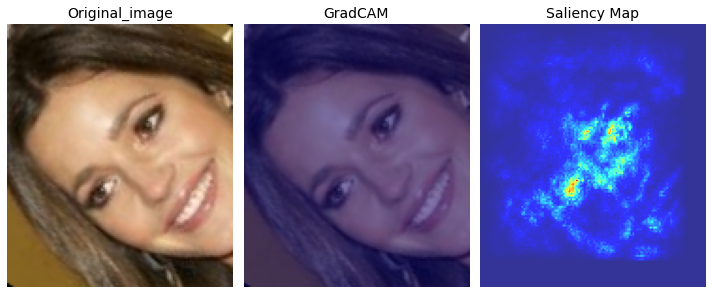

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
cam=gradcam_graphs(model, images[0][0], images[0][1])
heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
heatmap = np.reshape(heatmap,(140,120,3))
#ax[i].set_title(title, fontsize=14)
ax[0].set_title('Original_image', fontsize=14)
ax[1].set_title('GradCAM', fontsize=14)
ax[2].set_title('Saliency Map', fontsize=14)
ax[0].imshow(images[0][0])
ax[1].imshow(images[0][0])
ax[1].imshow(heatmap, cmap='jet', alpha=0.5)# overlay
ax[2].imshow(saliency_graphs(model, images[0][0], images[0][1])[0], cmap='jet',alpha=0.8)
ax[0].grid(False)
ax[0].axis('off')
ax[1].grid(False)
ax[1].axis('off')
ax[2].grid(False)
ax[2].axis('off')
plt.tight_layout()
plt.show()

*Your answer here*

# The model uses the eyes and nose as a feature. It looks at the position of eyes and nose and try to make eyes horizontal and nose vertical.

**2.3.2** **Correct an image of your choosing**.

Find an image or image(s) (not from the provided test/training sets), or make your own. You may rotate it yourself up to $\pm60^\circ$, or the face can already be naturally rotated. Resize and crop the image to 140px by 120px, load it here, and normalize it to [0.,1.] (you may use the provided `normalize_image` function) and use your network to correct it.

In [ ]:
# your code here
im=cv2.imread('test.png')

In [ ]:
label=30
im=normalize_image(im)
im2=rot_resize(im,label)
print(im2.shape)

(140, 120, 3)


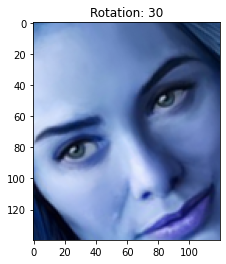

In [ ]:
plt.imshow(im2)
plt.title('Rotation: '+str(label))
plt.show()

In [ ]:
im3=rot_resize(im2,-model.predict(np.expand_dims(im2,axis=0))[0][0])

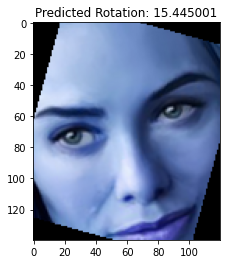

In [ ]:
plt.imshow(im3)
plt.title('Predicted Rotation: '+ str(model.predict(np.expand_dims(im2,axis=0))[0][0]))
plt.show()